In [1]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

In [30]:
"""
Анализ неизвестного распределения:
- сводная статистика
- визуализация (гистограмма + KDE, QQ-plot)
- подгонка кандидатов и ранжирование по AIC / AICc / BIC
- нормальные тесты: Shapiro, Anderson-Darling, KS, Lilliefors (KS with est. params)

Зависимости:
    pip install numpy scipy pandas matplotlib seaborn statsmodels
"""

import warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

warnings.filterwarnings("ignore")


def analyze_distribution(x):
    # ----- 1) Сводная статистика -----
    n = x.size
    mean = float(np.mean(x))
    std_unbiased = float(np.std(x, ddof=1))
    min_, max_ = float(np.min(x)), float(np.max(x))
    skew = st.skew(x, bias=False)
    kurt = st.kurtosis(x, fisher=True, bias=False)  # эксцесс

    print("Summary:")
    print(f"  n            = {n}")
    print(f"  mean         = {mean:.3f}")
    print(f"  std (ddof=1) = {std_unbiased:.3f}")
    print(f"  min..max     = {min_:.3f} .. {max_:.3f}")
    print(f"  skew         = {skew:.3f}")
    print(f"  kurtosis     = {kurt:.3f}")
    print()

    # ----- 2) Визуализация распределения + MLE Normal -----
    # sns.set(style="whitegrid", context="talk")

    # MLE-параметры нормального распределения
    mu_mle, sigma_mle = st.norm.fit(x)

    # Сетка и MLE-плотность
    x_grid = np.linspace(x.min() - 3 * sigma_mle, x.max() + 3 * sigma_mle, 400)
    pdf_mle = st.norm.pdf(x_grid, loc=mu_mle, scale=sigma_mle)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    sns.histplot(x, kde=True, stat="density", bins="sqrt", edgecolor="black", ax=ax)

    # Кривая MLE
    (line_mle,) = ax.plot(
        x_grid,
        pdf_mle,
        linewidth=2,
        # label=rf"Normal MLE PDF ($\mu={mu_mle:.2f}$, $\sigma={sigma_mle:.2f}$)",
        label=rf"MLE Плотности Норм. Распр. ($\mu={mu_mle:.2f}$, $\sigma={sigma_mle:.2f}$)",
        c="red",
    )

    # Найдём линию KDE (если seaborn её добавил в ax.lines)
    kde_line = None
    for l in ax.lines:
        if l is not line_mle:
            kde_line = l
            break

    handles = []
    labels = []
    if kde_line is not None:
        handles.append(kde_line)
        labels.append("KDE")
    handles.append(line_mle)
    labels.append(line_mle.get_label())

    # ax.set_title("Гистограмма, KDE и MLE нормальная плотность")
    # ax.set_title("KDE and MLE for Gaussian")
    ax.set_xlabel("$x$")
    ax.set_ylabel("Плотность")
    # ax.set_ylabel("Density")

    # Легенда под графиком, вне области осей (в одну строку)
    ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.22),
        ncol=len(handles),
        frameon=False,
    )
    plt.tight_layout(rect=(0, 0.12, 1, 1))
    # plt.show()
    fig.savefig("../outputs/figures/normal-dist.pdf")

    # QQ-plot против нормального
    fig, ax = plt.subplots(figsize=(6, 6))
    (osm, osr), (slope, intercept, r) = st.probplot(x, dist="norm", plot=ax)
    ax.set_title("QQ-график (Нормальность)")
    plt.tight_layout()
    plt.show()
    print(f"QQ line: slope≈{slope:.3f}, intercept≈{intercept:.3f}, r={r:.4f}\n")

    # ----- 3) Тесты нормальности -----
    alpha = 0.05

    # Shapiro–Wilk
    sh_W, sh_p = st.shapiro(x)

    # Anderson–Darling (возвращает критические значения; p не даёт)
    ad = st.anderson(x, dist="norm")
    # Критерий на уровне 5%
    try:
        idx5 = list(ad.significance_level).index(5.0)
    except ValueError:
        # по умолчанию в SciPy есть 5%; если нет — берём ближайший
        idx5 = int(np.argmin(np.abs(np.asarray(ad.significance_level) - 5.0)))
    ad_crit5 = float(ad.critical_values[idx5])
    ad_reject = ad.statistic > ad_crit5

    # KS на стандартизированных данных (формально оптимистичен)
    zs = (x - np.mean(x)) / np.std(x, ddof=0)
    ks_D, ks_p = st.kstest(zs, "norm")

    # Лиллиефорс (корректный KS при оценке параметров) — опционально
    lf_D = lf_p = None
    try:
        from statsmodels.stats.diagnostic import lilliefors

        lf_D, lf_p = lilliefors(x, dist="norm")
    except Exception:
        pass  # statsmodels не установлен — пропустим

    # D’Agostino–Pearson (совместность skew/kurt с нормой)
    dp_K2, dp_p = st.normaltest(x)

    # Сводная таблица по тестам
    rows = [
        {
            "Test": "Shapiro-Wilk",
            "Statistic": sh_W,
            "p_value": sh_p,
            "Reject@0.05": sh_p < alpha,
            "Notes": "",
        },
        {
            "Test": "Anderson-Darling",
            "Statistic": ad.statistic,
            "p_value": np.nan,
            "Reject@0.05": ad_reject,
            "Notes": f"crit(5%)={ad_crit5:.3f}",
        },
        {
            "Test": "Kolmogorov-Smirnov (approx)",
            "Statistic": ks_D,
            "p_value": ks_p,
            "Reject@0.05": ks_p < alpha,
            "Notes": "params estimated; use Lilliefors",
        },
        {
            "Test": "D'Agostino-Pearson",
            "Statistic": dp_K2,
            "p_value": dp_p,
            "Reject@0.05": dp_p < alpha,
            "Notes": "",
        },
    ]
    if lf_D is not None:
        rows.insert(
            3,
            {
                "Test": "Lilliefors (KS with est. params)",
                "Statistic": lf_D,
                "p_value": lf_p,
                "Reject@0.05": lf_p < alpha,
                "Notes": "",
            },
        )

    tests_df = pd.DataFrame(
        rows, columns=["Test", "Statistic", "p_value", "Reject@0.05", "Notes"]
    )
    pd.set_option("display.precision", 6)
    print("Normality tests summary (alpha=0.05):")
    print(tests_df.to_string(index=False))
    print()

    # Авто-интерпретация
    def verdict(df: pd.DataFrame) -> str:
        rej = df.set_index("Test")["Reject@0.05"]
        flags = []
        # приоритетные (наиболее уместные) тесты
        if "Lilliefors (KS w/ est. params)" in rej.index:
            flags.append(rej["Lilliefors (KS w/ est. params)"])
        flags.append(rej.get("Shapiro–Wilk", False))
        flags.append(rej.get("D’Agostino–Pearson", False))
        # если любой приоритетный отверг — сообщаем
        if any(flags):
            return "Имеются статистические основания отвергнуть нормальность (на уровне 5%)."
        # если только AD ругается — вероятно, проблема в хвостах
        if rej.get("Anderson-Darling", False):
            return "Есть признаки отклонений в хвостах, но основные тесты нормальность не отвергли."
        return "Не найдено оснований отвергать нормальность на уровне 5%."

    print("Interpretation:", verdict(tests_df))
    print()

    # ----- 4) Подгонка кандидатных распределений и ранжирование -----
    candidates = {
        "normal": st.norm,
        "lognorm": st.lognorm,  # shape, loc, scale
        "gamma": st.gamma,  # a, loc, scale
        "expon": st.expon,  # loc, scale
        "uniform": st.uniform,  # loc, scale
    }

    @dataclass
    class FitResult:
        name: str
        params: Tuple[float, ...]
        ll: float
        k: int
        aic: float
        aicc: float
        bic: float
        ks_D: float
        ks_p: float

    def fit_and_score(name: str, dist, data: np.ndarray) -> FitResult:
        params = dist.fit(data)
        ll = float(np.sum(dist.logpdf(data, *params)))
        k = len(params)
        aic = 2 * k - 2 * ll
        aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if (n - k - 1) > 0 else np.inf
        bic = np.log(n) * k - 2 * ll
        # KS (ориентировочно, т.к. параметры оценены по той же выборке)
        D, p = st.kstest(data, dist.name, args=params)
        return FitResult(name, params, ll, k, aic, aicc, bic, D, p)

    rows_fit: List[FitResult] = []
    for name, dist in candidates.items():
        try:
            rows_fit.append(fit_and_score(name, dist, x))
        except Exception as e:
            print(f"[WARN] {name}: fit failed -> {e}")

    if rows_fit:
        df = (
            pd.DataFrame(
                [
                    {
                        "dist": r.name,
                        "k": r.k,
                        "logLik": r.ll,
                        "AIC": r.aic,
                        "AICc": r.aicc,
                        "BIC": r.bic,
                        "KS_D": r.ks_D,
                        "KS_p": r.ks_p,
                        "params": r.params,
                    }
                    for r in rows_fit
                ]
            )
            .sort_values("AICc")
            .reset_index(drop=True)
        )

        # ΔAICc и веса Акаике
        min_aicc = df["AICc"].min()
        df["ΔAICc"] = df["AICc"] - min_aicc
        weights = np.exp(-0.5 * df["ΔAICc"].values)
        df["Akaike_w"] = weights / weights.sum()

        pd.set_option("display.max_colwidth", None)
        print("\nModel comparison (sorted by AICc):")
        print(
            df[
                [
                    "dist",
                    "k",
                    "AIC",
                    "AICc",
                    "BIC",
                    "ΔAICc",
                    "Akaike_w",
                    "KS_D",
                    "KS_p",
                    "params",
                ]
            ].to_string(index=False)
        )

        # ----- 5) Быстрый вывод -----
        best = df.iloc[0]
        print("\nBest by AICc:", best["dist"])
        if best["dist"] == "normal":
            mu, sigma = best["params"]
            print(f"  μ ≈ {mu:.2f}, σ ≈ {sigma:.2f}")
            print(
                "Рекомендация: принять нормальную модель; при появлении новых данных перепроверить ранжирование."
            )
        else:
            print(
                "Рекомендация: сравнить эмпирические CDF/PDF с лучшей моделью, проверить остатки и при возможности собрать больше данных."
            )

Summary:
  n            = 200
  mean         = 206961.190
  std (ddof=1) = 2724.222
  min..max     = 198716.000 .. 214052.000
  skew         = -0.116
  kurtosis     = 0.303



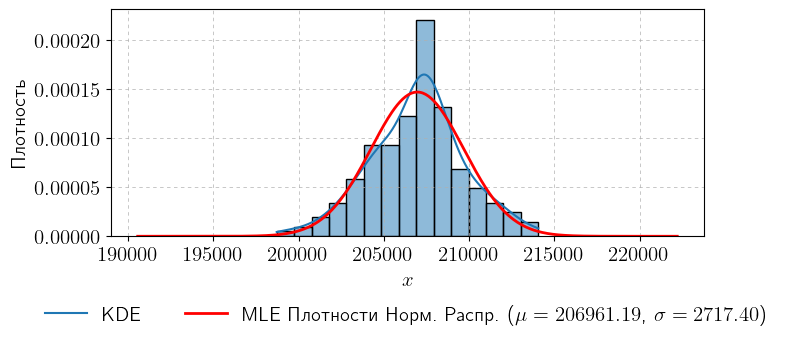

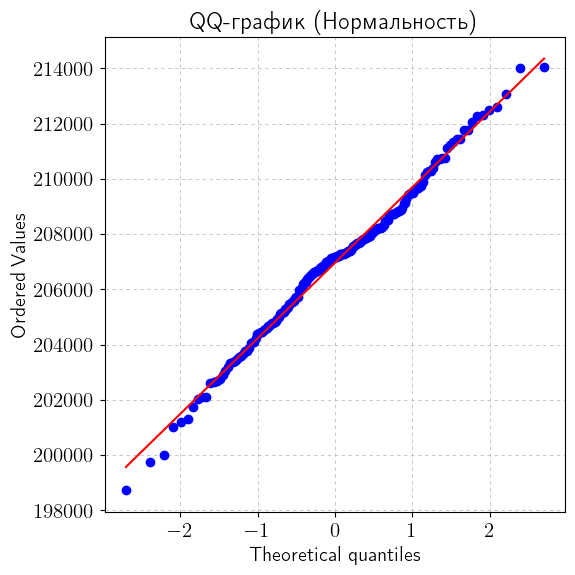

QQ line: slope≈2737.422, intercept≈206961.190, r=0.9961

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.992429 0.389652        False                                 
                Anderson-Darling   0.658813      NaN        False                   crit(5%)=0.772
     Kolmogorov-Smirnov (approx)   0.061527 0.418517        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.061684 0.064215        False                                 
              D'Agostino-Pearson   1.385988 0.500077        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                           params
 normal  2 3734.548166 3734.609080 3741.1

In [31]:
import FewShotCVRP.examples.analysis.ea_stats_store as ea_stats
from importlib import reload


reload(ea_stats)

_st = ea_stats.EAStatsStore()
_st.load_raw("../analysis/ea_runs/raw_runs.parquet")

best_so_far = _st._raw.loc[
    (_st._raw["algorithm_name"] == "few_shot")
    & (_st._raw["cvrp_instance_name"] == "X-n641-k35.xml")
    & (_st._raw["evals"] == 1000001),
    "best_so_far",
].to_numpy()

analyze_distribution(best_so_far)


In [4]:
import noise_study_logger as nlg

mp = {}
for line in nlg.iter_records(
    "noise_study.jsonl.gz"
):
    instance_path = line["instance_path"]
    if mp.get(instance_path) is None:
        mp[instance_path] = [line]
    else:
        mp[instance_path].append(line)

print(mp.keys())

dict_keys(['X-n153-k22.xml', 'X-n176-k26.xml', 'X-n491-k59.xml', 'X-n308-k13.xml', 'X-n209-k16.xml', 'X-n237-k14.xml', 'X-n280-k17.xml', 'X-n420-k130.xml', 'X-n524-k137.xml', 'X-n101-k25.xml'])


In [12]:
np.array(line["values"])

array([38355., 38770., 38054., 38695., 39801., 38792., 39181., 38710.,
       39446., 38840., 38484., 39559., 38199., 38282., 39885., 38991.,
       39189., 40474., 38106., 39197., 39173., 38690., 38345., 37985.,
       39433., 39192., 38652., 38005., 38686., 37986., 38031., 39496.,
       37799., 39126., 38447., 39179., 38568., 38983., 39385., 38780.,
       39121., 38330., 37974., 39398., 38276., 39047., 38677., 38198.,
       39273., 39398., 38306., 38738., 37545., 39573., 38755., 39516.,
       39167., 40140., 37537., 38894., 38508., 37869., 39207., 39322.,
       39295., 39292., 37790., 38385., 38943., 38305., 39719., 38807.,
       39794., 38525., 38438., 38892., 39515., 39286., 37785., 38674.,
       39792., 39004., 37869., 38972., 37665., 37764., 39312., 38927.,
       38538., 38039., 39818., 39318., 39818., 38668., 39094., 39793.,
       39614., 38526., 38397.])

Summary:
  n            = 99
  mean         = 175715.141
  std (ddof=1) = 1685.760
  min..max     = 171877.000 .. 179343.000
  skew         = -0.029
  kurtosis     = -0.567



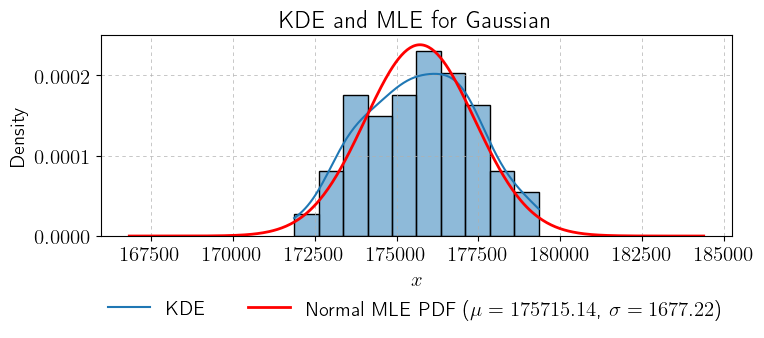

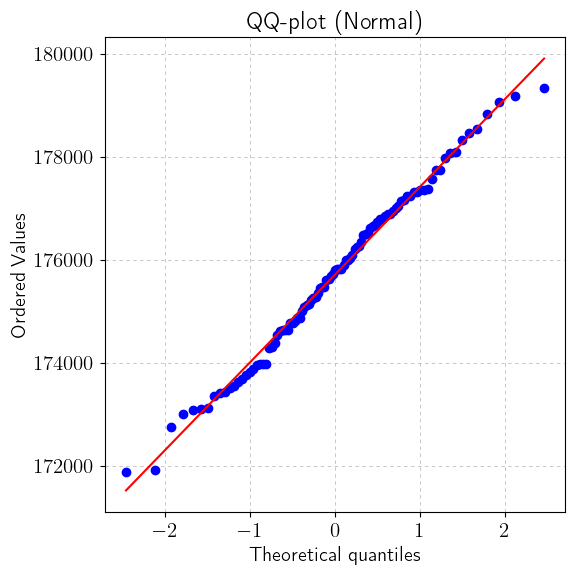

QQ line: slope≈1705.992, intercept≈175715.141, r=0.9966

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.989258 0.612091        False                                 
                Anderson-Darling   0.258998      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.061817 0.821010        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.060590 0.500054        False                                 
              D'Agostino-Pearson   2.123656 0.345823        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC     ΔAICc     Akaike_w     KS_D     KS_p                                                         params
 normal  2 1755.079187 1755.204187 1760.269427  

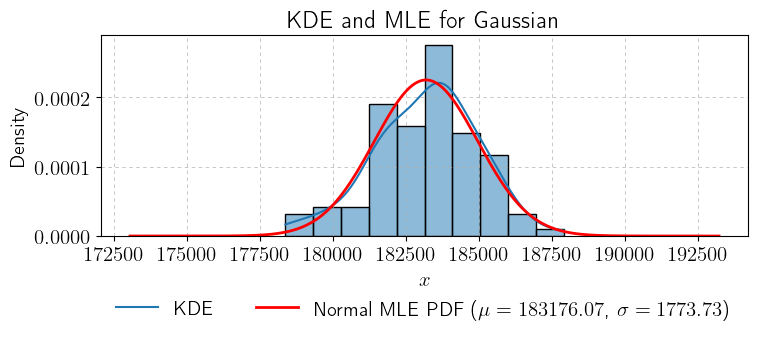

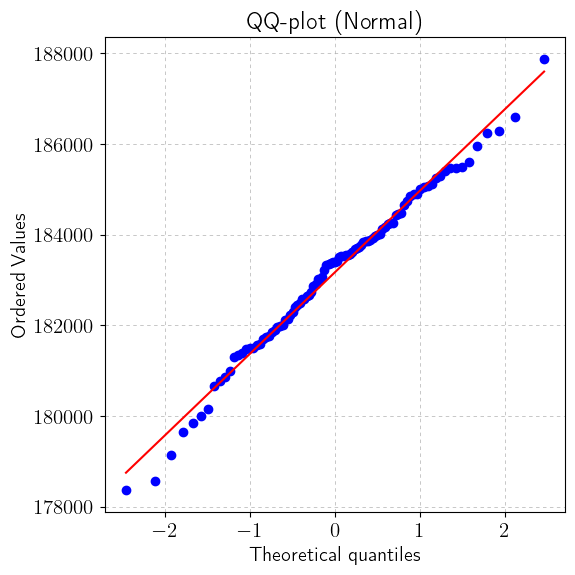

QQ line: slope≈1799.658, intercept≈183176.071, r=0.9941

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.989330 0.617773        False                                 
                Anderson-Darling   0.351599      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.079584 0.531195        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.079412 0.140034        False                                 
              D'Agostino-Pearson   1.968544 0.373711        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                           params
 normal  2 1766.156367 1766.281367 1771.3

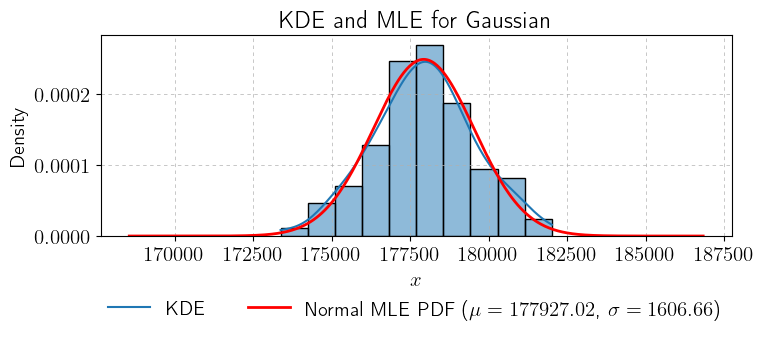

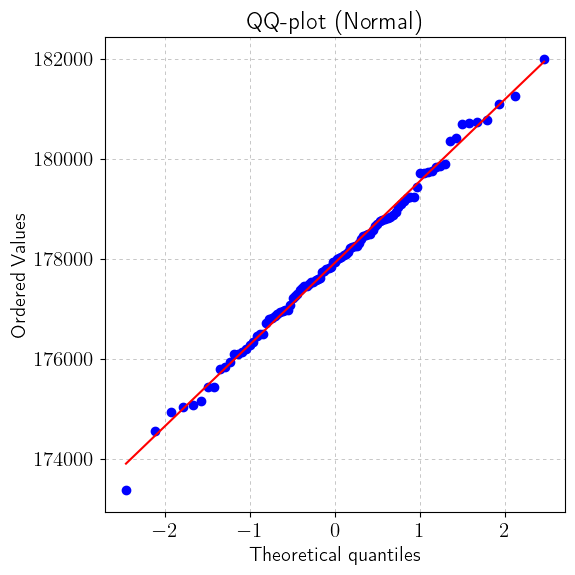

QQ line: slope≈1636.048, intercept≈177927.020, r=0.9977

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.996146 0.994731        False                                 
                Anderson-Darling   0.138807      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.034327 0.999573        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.035332 0.990000        False                                 
              D'Agostino-Pearson   0.145452 0.929856        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                          params
 normal  2 1746.569172 1746.694172 1751.75

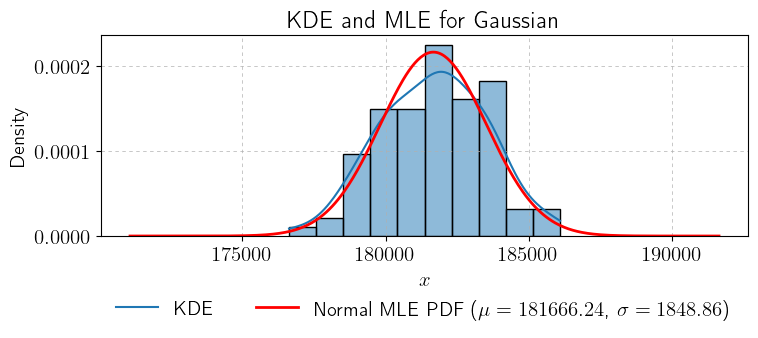

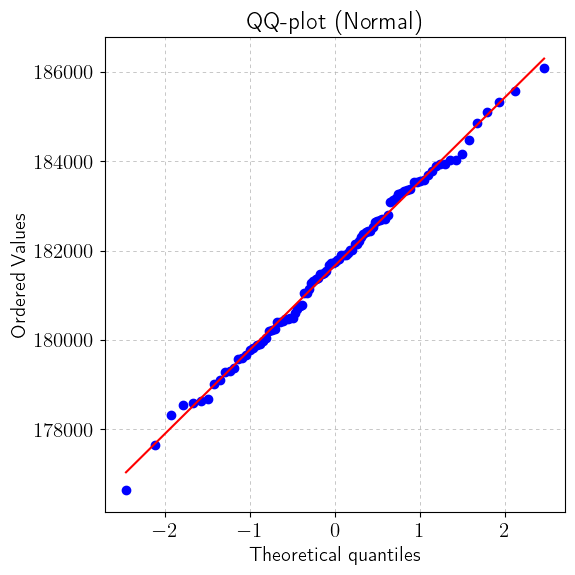

QQ line: slope≈1883.004, intercept≈181666.242, r=0.9979

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.995148 0.979667        False                                 
                Anderson-Darling   0.175678      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.050808 0.948873        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.049757 0.794949        False                                 
              D'Agostino-Pearson   0.293870 0.863350        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                         params
 normal  2 1774.370173 1774.495173 1779.560

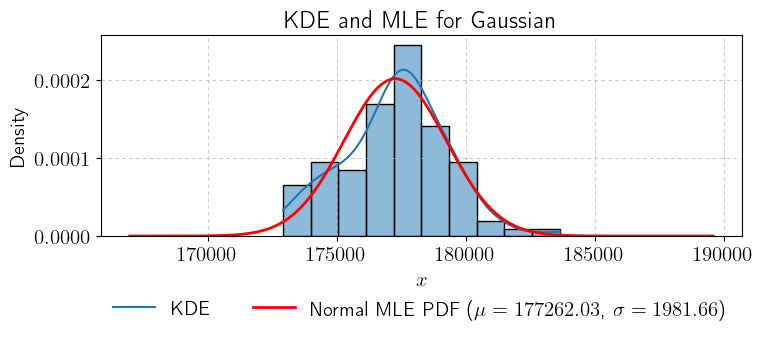

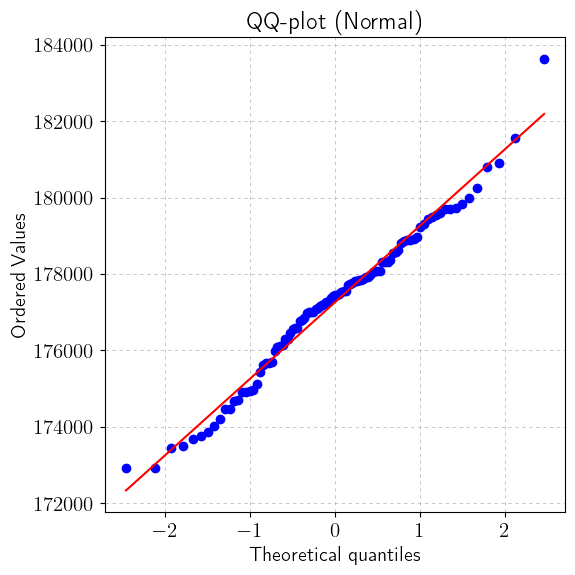

QQ line: slope≈2004.596, intercept≈177262.030, r=0.9911

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.983559 0.254952        False                                 
                Anderson-Darling   0.535509      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.079179 0.537719        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.079467 0.139291        False                                 
              D'Agostino-Pearson   0.712915 0.700152        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC     ΔAICc     Akaike_w     KS_D         KS_p                                                          params
 normal  2 1788.104853 1788.229853 1793.295

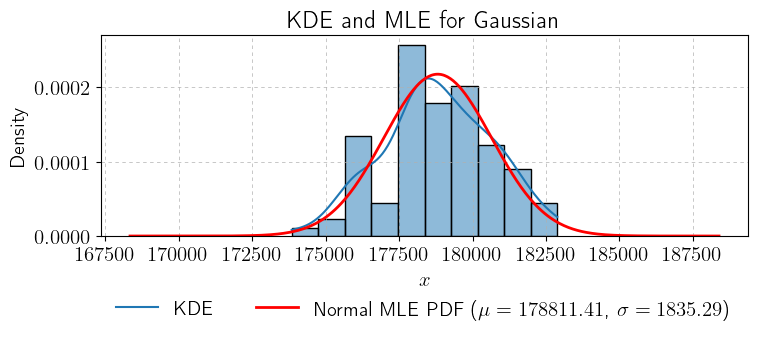

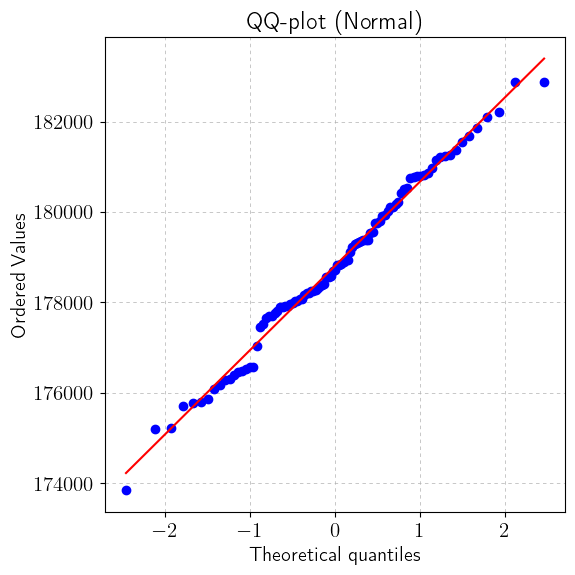

QQ line: slope≈1865.054, intercept≈178811.414, r=0.9957

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.989811 0.656127        False                                 
                Anderson-Darling   0.350017      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.062652 0.808582        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.063695 0.427179        False                                 
              D'Agostino-Pearson   0.347924 0.840329        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                            params
 normal  2 1772.911714 1773.036714 1778.

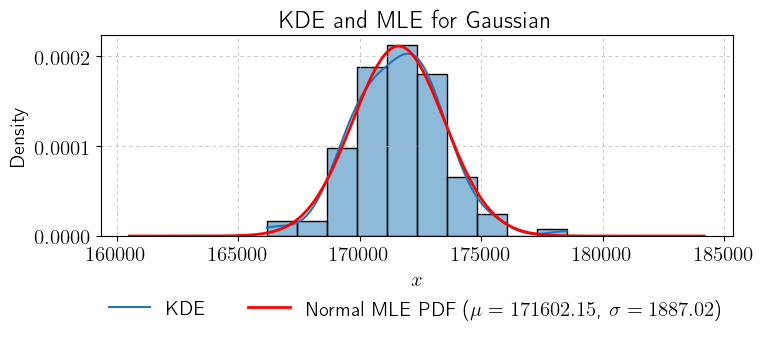

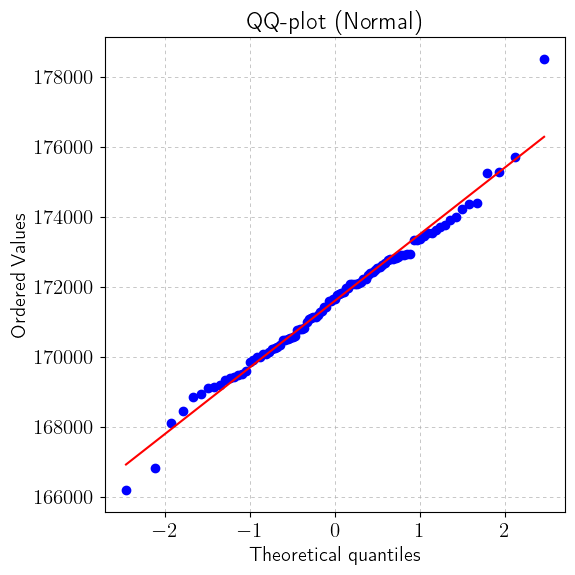

QQ line: slope≈1903.275, intercept≈171602.152, r=0.9882

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.983866 0.268554        False                                 
                Anderson-Darling   0.275122      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.056530 0.891860        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.057647 0.583012        False                                 
              D'Agostino-Pearson   5.620832 0.060180        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                        params
 normal  2 1778.414660 1778.539660 1783.6048

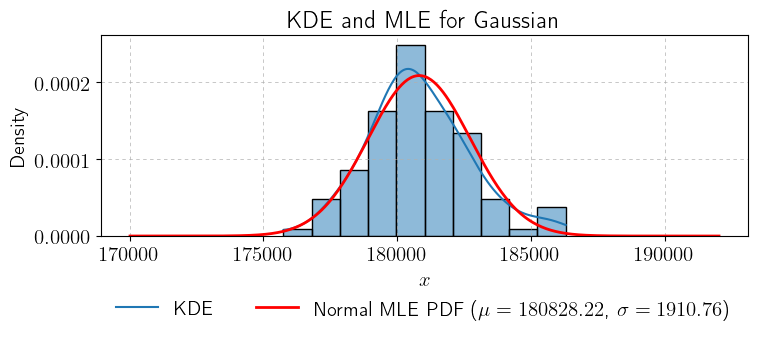

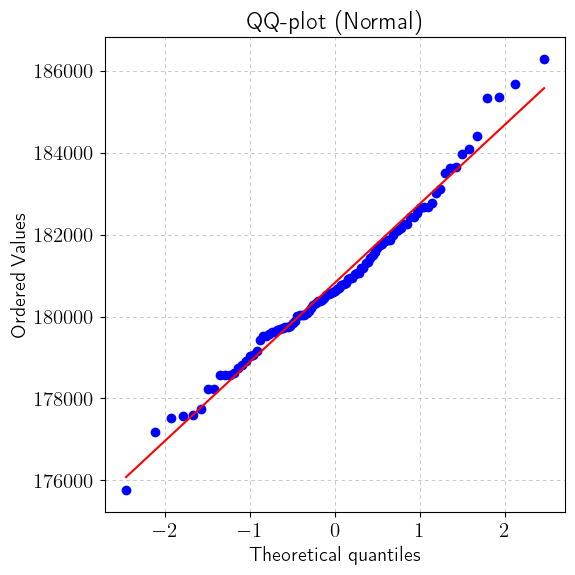

QQ line: slope≈1933.052, intercept≈180828.222, r=0.9912

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.984453 0.296307        False                                 
                Anderson-Darling   0.497328      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.068302 0.718697        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.068544 0.313424        False                                 
              D'Agostino-Pearson   3.906629 0.141803        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                       params
 normal  2 1780.890616 1781.015616 1786.08085

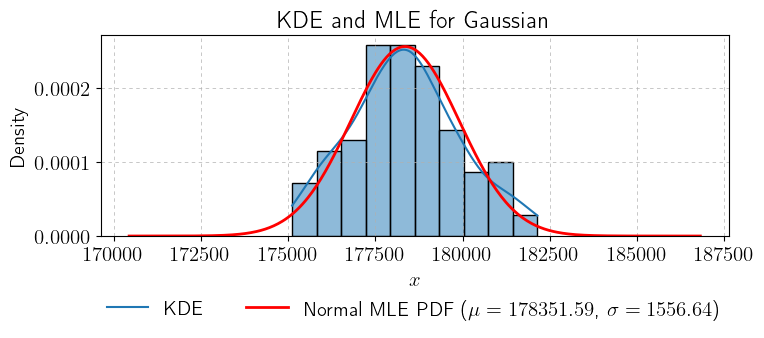

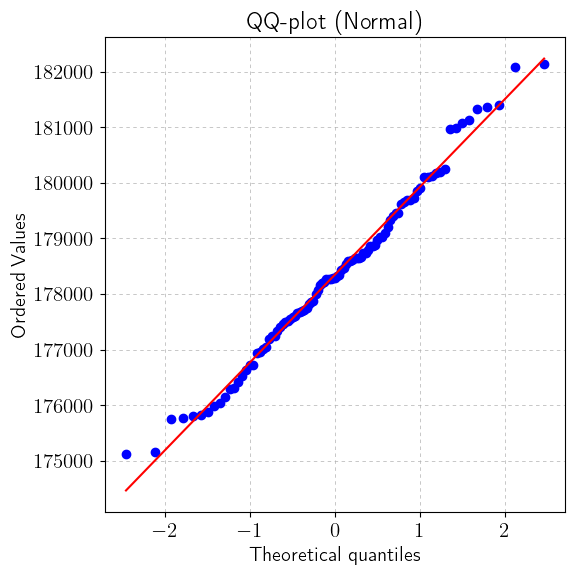

QQ line: slope≈1580.917, intercept≈178351.586, r=0.9951

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.986749 0.428293        False                                 
                Anderson-Darling   0.284963      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.052309 0.936161        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.052964 0.715072        False                                 
              D'Agostino-Pearson   0.980288 0.612538        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC     ΔAICc     Akaike_w     KS_D     KS_p                                                        params
 normal  2 1740.306605 1740.431605 1745.496844  0

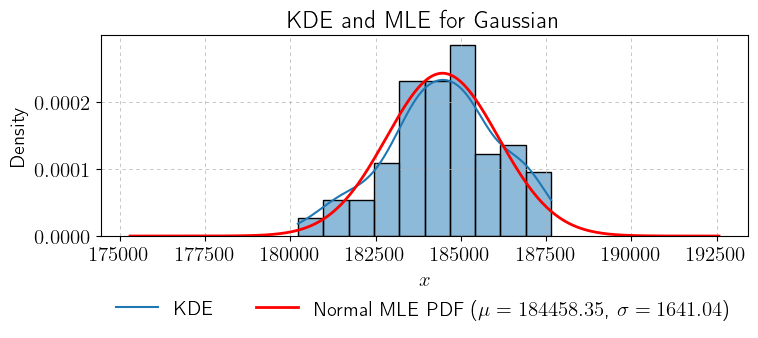

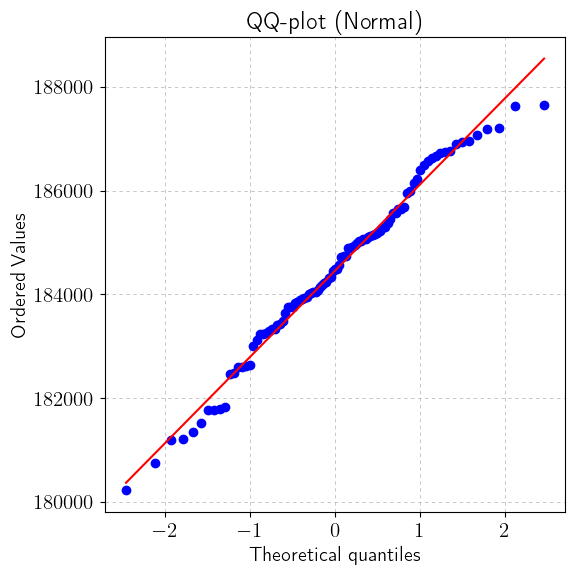

QQ line: slope≈1664.131, intercept≈184458.354, r=0.9936

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.983679 0.260203        False                                 
                Anderson-Darling   0.373849      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.051278 0.945068        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.052068 0.740332        False                                 
              D'Agostino-Pearson   1.373799 0.503134        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                     params
 normal  2 1750.760755 1750.885755 1755.950995 

In [5]:
for line in mp["X-n491-k59.xml"]:
    analyze_distribution(np.array(line["values"]))
    # break

In [3]:
import noise_study_logger as nlg

mp = {}
for line in nlg.iter_records(
    "../outputs/noise_study_nn_2025-08-22-14h30m00s/noise_study_1.jsonl.gz"
):
    instance_path = line["instance_path"]
    if mp.get(instance_path) is None:
        mp[instance_path] = [line]
    else:
        mp[instance_path].append(line)

print(mp.keys())

dict_keys(['X-n101-k25.xml'])


In [7]:
myplots.default_plt_config()

Summary:
  n            = 100
  mean         = 30782.080
  std (ddof=1) = 463.810
  min..max     = 29604.000 .. 32069.000
  skew         = -0.037
  kurtosis     = 0.402



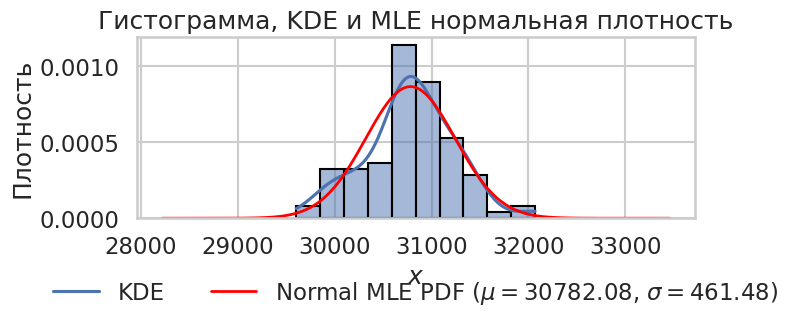

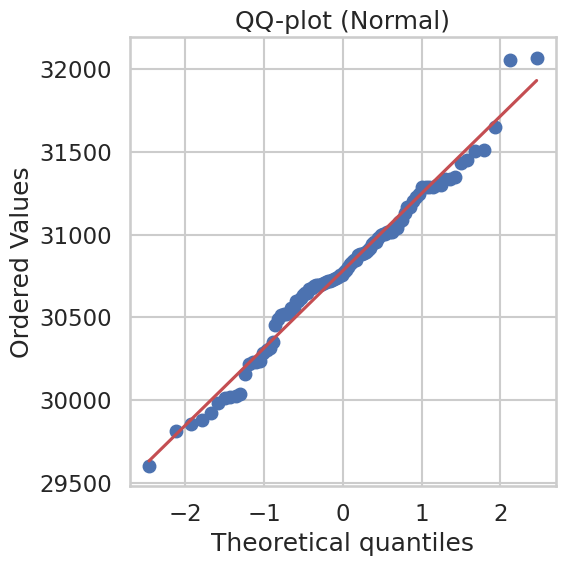

QQ line: slope≈466.733, intercept≈30782.080, r=0.9911

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.983507 0.246713        False                                 
                Anderson-Darling   0.604270      NaN        False                   crit(5%)=0.759
     Kolmogorov-Smirnov (approx)   0.075733 0.588087        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.076197 0.175154        False                                 
              D'Agostino-Pearson   0.929354 0.628338        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC      ΔAICc     Akaike_w     KS_D         KS_p                                                       params
 normal  2 1514.677611 1514.801323 1519.887952 

In [8]:
for line in mp["X-n101-k25.xml"]:
    analyze_distribution(np.array(line["values"]))
    break

dict_keys(['X-n101-k25.xml'])
Summary:
  n            = 99
  mean         = 30877.293
  std (ddof=1) = 393.648
  min..max     = 29940.000 .. 31947.000
  skew         = 0.307
  kurtosis     = -0.181



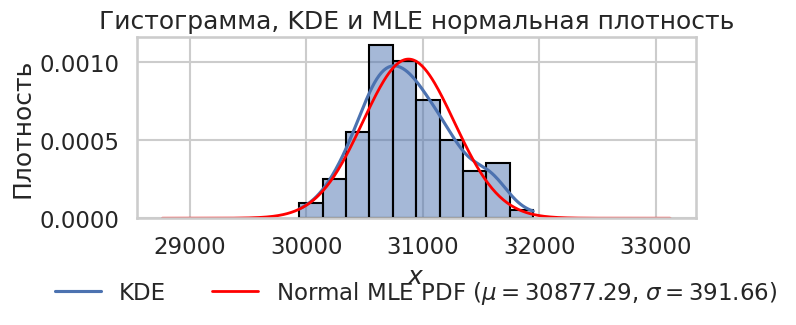

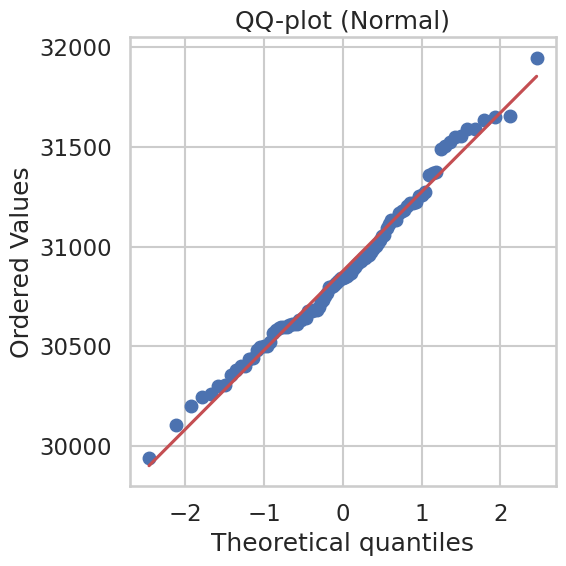

QQ line: slope≈397.177, intercept≈30877.293, r=0.9936

Normality tests summary (alpha=0.05):
                            Test  Statistic  p_value  Reject@0.05                            Notes
                    Shapiro-Wilk   0.986587 0.417729        False                                 
                Anderson-Darling   0.485171      NaN        False                   crit(5%)=0.758
     Kolmogorov-Smirnov (approx)   0.066516 0.747971        False params estimated; use Lilliefors
Lilliefors (KS with est. params)   0.065619 0.382043        False                                 
              D'Agostino-Pearson   1.708805 0.425537        False                                 

Interpretation: Не найдено оснований отвергать нормальность на уровне 5%.


Model comparison (sorted by AICc):
   dist  k         AIC        AICc         BIC     ΔAICc     Akaike_w     KS_D         KS_p                                                        params
 normal  2 1467.085469 1467.210469 1472.275709 

In [9]:
mp = {}
for line in nlg.iter_records(
    "../outputs/noise_study_2025-08-22-14h48m43s/noise_study_1.jsonl.gz"
):
    instance_path = line["instance_path"]
    if mp.get(instance_path) is None:
        mp[instance_path] = [line]
    else:
        mp[instance_path].append(line)

print(mp.keys())

for line in mp["X-n101-k25.xml"]:
    analyze_distribution(np.array(line["values"]))
    break